# Import Library

In [1]:
import os, random
import pandas as pd
import numpy as np
import itertools, cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Preprocessing Data

In [2]:
dataset_paths = ['/kaggle/input/fracturefusion-a-symphony-of-bone-breaks']

In [3]:
count_dist = defaultdict(int)
original_images = []
labels = []

for path in dataset_paths:
    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:
            image = cv2.imread(os.path.join(dirpath, filename))
            image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
            image = cv2.addWeighted(image, 1.5, image, -0.15,-0.15)            
            label = dirpath.split('/')[-1]
            if label in ["Avulsion fracture", "Hairline Fracture", "Impacted fracture", "Longitudinal fracture", "Pathological fracture"]:
                continue
            count_dist[label] += 1
            original_images.append(image)
            labels.append(label)
len(original_images), len(labels)

(597, 597)

# Augmentasi Data

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

def img_augmentation(images, k=8):
    img_augmentation_layers = [
        tf.keras.layers.RandomRotation(factor=0.15, seed=seed),
        tf.keras.layers.RandomFlip(seed=seed),
        tf.keras.layers.RandomContrast(factor=0.1, seed=seed),
    ]
    
    augmented_images = []
    for img in images:
        for i in range(k):
            img_tensor = tf.convert_to_tensor(img)

            for layer in img_augmentation_layers:
                img_tensor = layer(img_tensor)

            augmented_img = img_tensor.numpy()
            augmented_images.append(augmented_img)
    return augmented_images

data_dict = defaultdict(list)
aug_dict = defaultdict(list)

for i, img in enumerate(original_images):
    data_dict[labels[i]].append(img)

for label, images in data_dict.items():
    aug_dict[label] = img_augmentation(images, k=8)

output_dir = '/kaggle/working/pengolahan_data'
os.makedirs(output_dir, exist_ok=True)

for label, items in aug_dict.items():
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    
    for idx, img in enumerate(items):
        img_path = os.path.join(label_dir, f'{label}_{idx}.png')
        Image.fromarray(img.astype(np.uint8)).save(img_path)

for idx, img in enumerate(original_images):
    label = labels[idx]
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    img_path = os.path.join(label_dir, f'{label}_original_{idx}.png')
    Image.fromarray(img.astype(np.uint8)).save(img_path)

print(f'Images saved to {output_dir}')

Images saved to /kaggle/working/pengolahan_data


# Load Result Data Preprocessing

In [5]:
data_dir = '/kaggle/working/pengolahan_data'  

file_paths = []
labels = []

data_folders = os.listdir(data_dir)

for folder in data_folders:
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):  
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(folder_path, img_file))
                labels.append(folder) 

df = pd.DataFrame({'filepaths': file_paths, 'labels': labels})
df.head()

,filepaths,labels
0,/kaggle/working/pengolahan_data/Comminuted fra...,Comminuted fracture
1,/kaggle/working/pengolahan_data/Comminuted fra...,Comminuted fracture
2,/kaggle/working/pengolahan_data/Comminuted fra...,Comminuted fracture
3,/kaggle/working/pengolahan_data/Comminuted fra...,Comminuted fracture
4,/kaggle/working/pengolahan_data/Comminuted fra...,Comminuted fracture


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5373 entries, 0 to 5372
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  5373 non-null   object
 1   labels     5373 non-null   object
dtypes: object(2)
memory usage: 84.1+ KB


In [7]:
label_counts = df['labels'].value_counts()
label_counts

labels
Fracture Dislocation    1404
Comminuted fracture     1332
Greenstick fracture     1098
Spiral Fracture          774
Oblique fracture         765
Name: count, dtype: int64

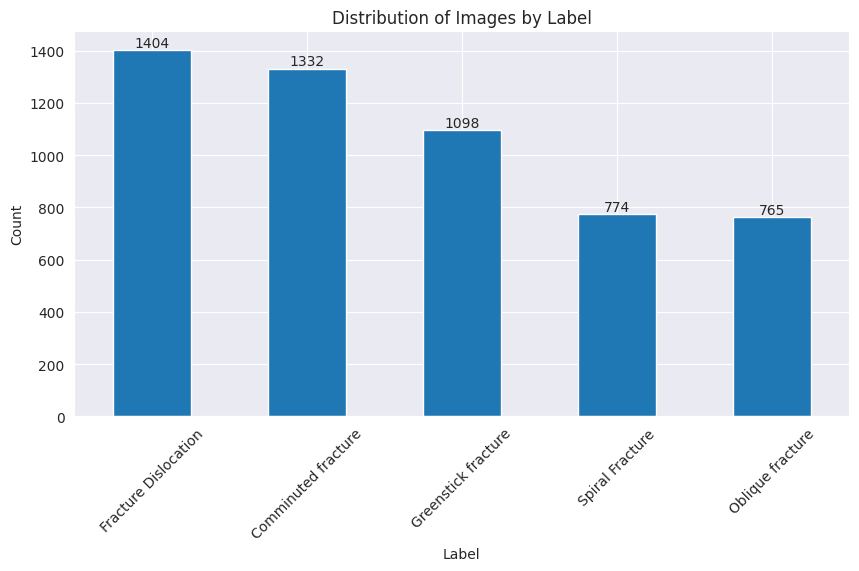

In [8]:
# Distribusi data 
plt.figure(figsize=(10, 5))
ax = label_counts.plot(kind='bar')
plt.title('Distribution of Images by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.show()

# Spliting Data

In [9]:
df_sorted = df.sort_values('filepaths').reset_index(drop=True)

train_split = 0.8
test_split = 0.1
dummy_split = test_split / (1 - train_split)

train_df, dummy_df = train_test_split(
    df_sorted, 
    train_size=train_split, 
    shuffle=True, 
    stratify=df_sorted['labels']
)

test_df, valid_df = train_test_split(
    dummy_df, 
    train_size=dummy_split, 
    shuffle=True, 
    stratify=dummy_df['labels']
)

print('train_df length: ', len(train_df), 
      '  test_df length: ', len(test_df), 
      '  valid_df length: ', len(valid_df))

train_df length:  4298   test_df length:  537   valid_df length:  538


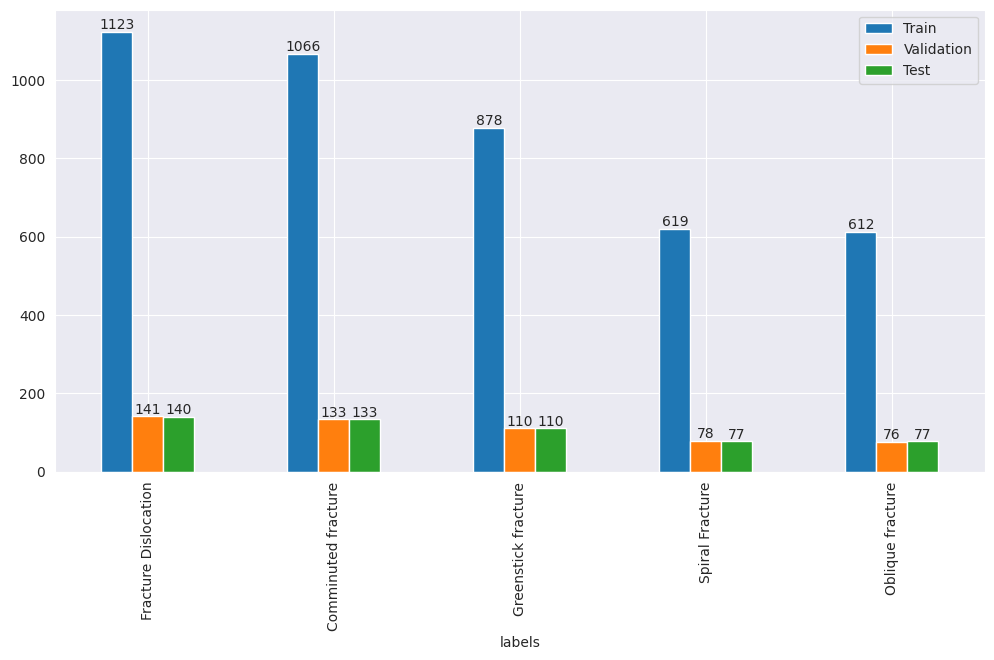

In [10]:
train_counts = train_df['labels'].value_counts()
valid_counts = valid_df['labels'].value_counts()
test_counts = test_df['labels'].value_counts()

label_distribution = pd.DataFrame({
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
})

ax = label_distribution.plot(kind='bar', figsize=(12, 6))
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

In [11]:
height = 224
width  = 224
channels = 3
batch_size = 32

img_shape = (height, width, channels)
img_size  = (height, width)
length    =  len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps = int(length/test_batch_size)

print('test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  3   test steps:  179


In [12]:
gen=ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2
    )

train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print(classes)
class_count=len(classes)

Found 4298 validated image filenames belonging to 5 classes.
Found 538 validated image filenames belonging to 5 classes.
Found 537 validated image filenames belonging to 5 classes.
['Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Oblique fracture', 'Spiral Fracture']


In [13]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
    plt.show()

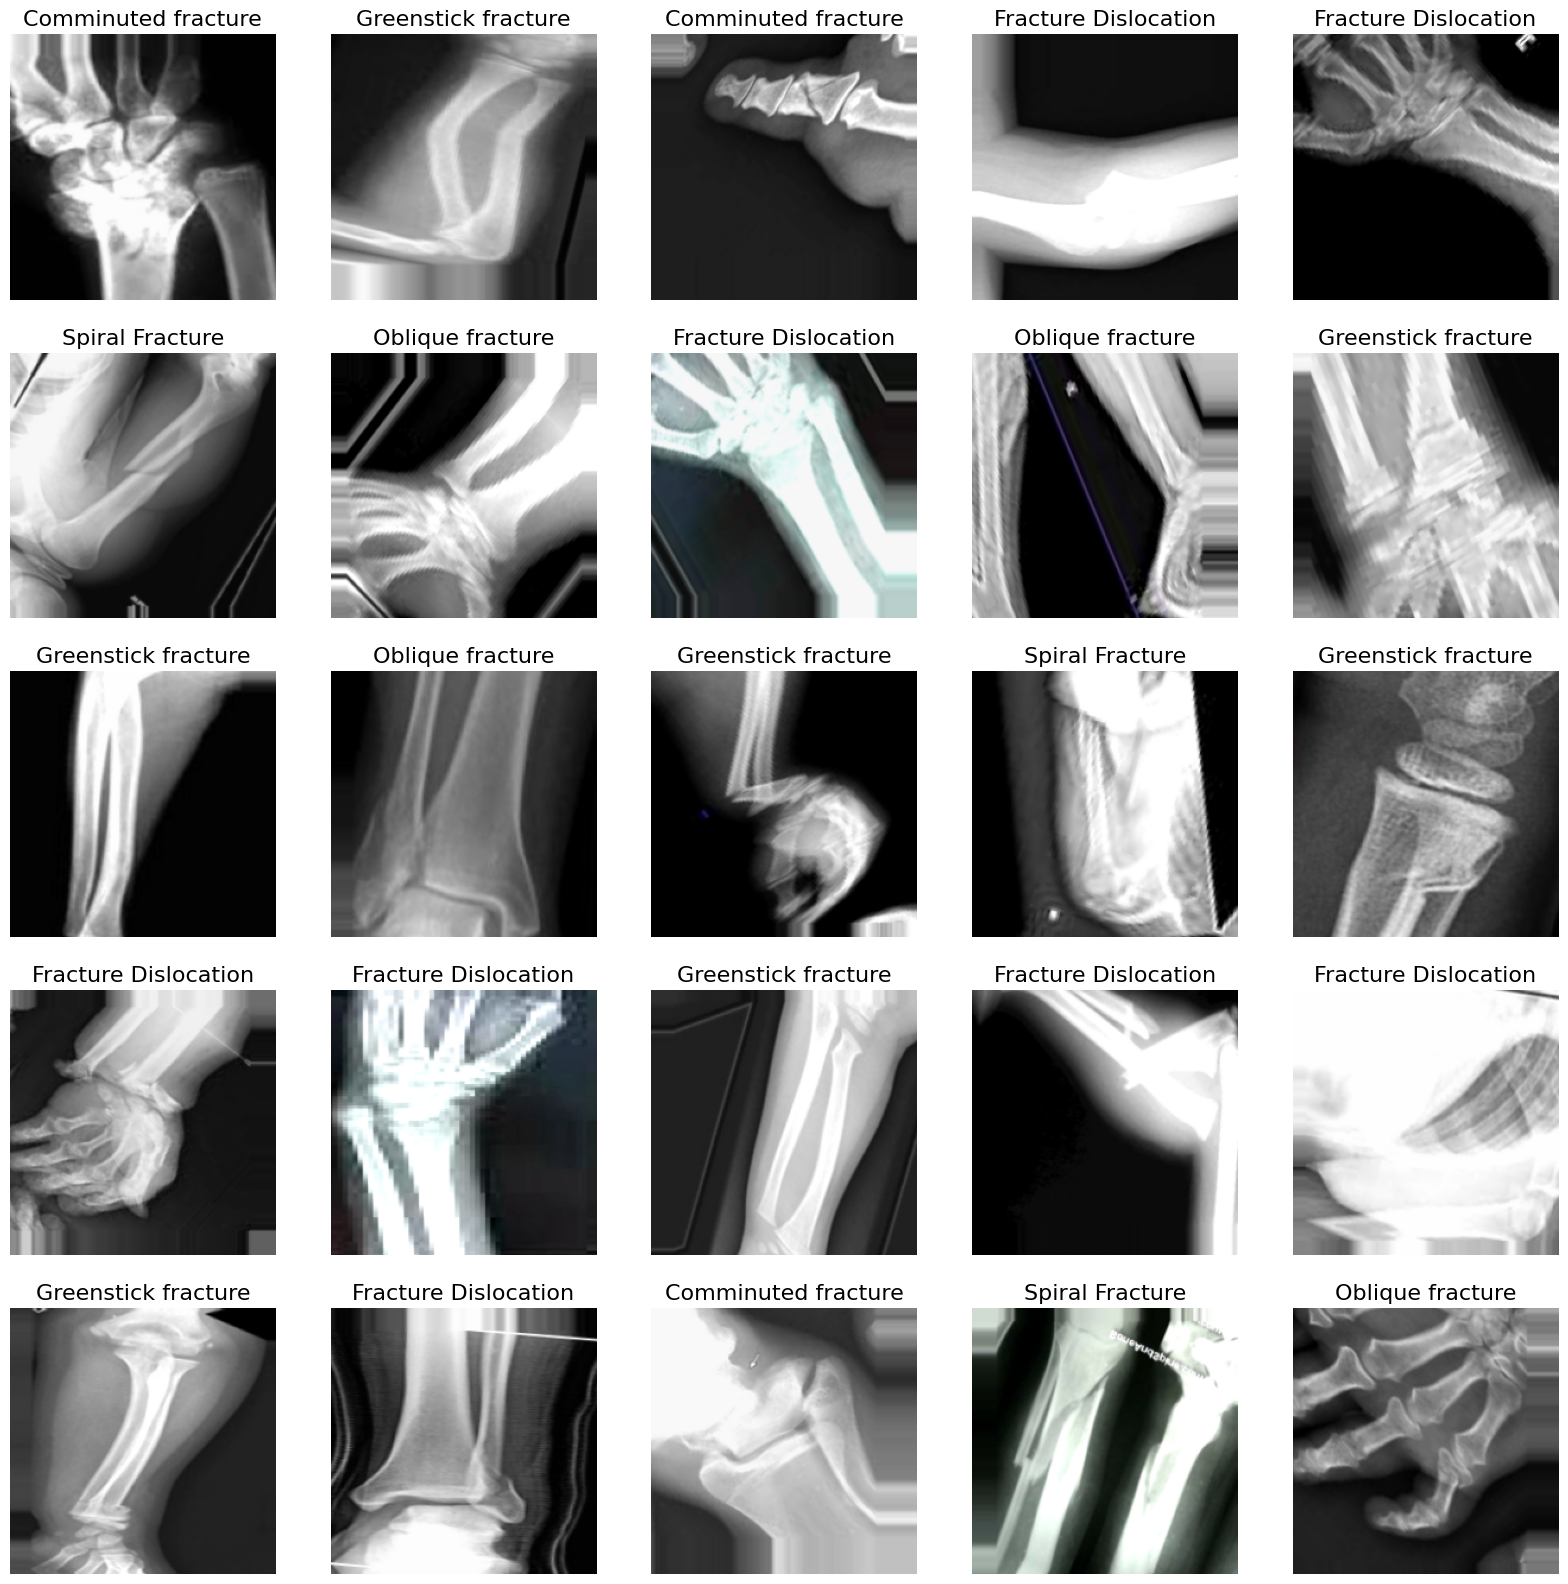

In [14]:
show_image_samples(train_gen)

# Modeling MobileNet with SE Block

In [15]:
def se_block(input_tensor, reduction_ratio=4):

    # Step 1: Global Average Pooling (Squeeze)
    channels = input_tensor.shape[-1]  
    squeeze = layers.GlobalAveragePooling2D()(input_tensor) 
    squeeze = layers.Reshape((1, 1, channels))(squeeze) 

    # Step 2: Bottleneck Dense Layer (Excitation)
    excitation = layers.Dense(channels // reduction_ratio, activation='relu', use_bias=False)(squeeze)
    excitation = layers.Dense(channels, activation='sigmoid', use_bias=False)(excitation)

    # Step 3: Recalibrate Input Tensor dengan Attention Weight (Scale)
    scale = layers.Multiply()([input_tensor, excitation])

    # Skip Connection
    output = layers.Add()([input_tensor, scale])
    
    return output

In [17]:
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), 
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

x = base_model.output
se = se_block(x)
x = layers.GlobalAveragePooling2D()(se)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.3)(x) 
x = layers.Dense(64, activation='relu')(x)  
x = layers.Dropout(0.2)(x)  
output = layers.Dense(5, activation='softmax')(x) 

mobilenetse = models.Model(inputs=base_model.input, outputs=output)

mobilenetse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

In [18]:
mobilenetse.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 3,892,933 (14.85 MB)

 Trainable params: 664,069 (2.53 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

In [20]:
import time
start_time = time.time()

history = mobilenetse.fit(x=train_gen, epochs=100, validation_data=valid_gen, callbacks=[early_stopping])

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732205394.313868     104 service.cc:145] XLA service 0x571e325874b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732205394.313940     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732205394.313963     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/135 ━━━━━━━━━━━━━━━━━━━━ 31:37 14s/step - accuracy: 0.2188 - loss: 2.9666

I0000 00:00:1732205402.592785     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 68s 403ms/step - accuracy: 0.2940 - loss: 1.7594 - val_accuracy: 0.4721 - val_loss: 1.3372
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 333ms/step - accuracy: 0.4638 - loss: 1.3109 - val_accuracy: 0.6208 - val_loss: 1.0158
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 328ms/step - accuracy: 0.5511 - loss: 1.1525 - val_accuracy: 0.6561 - val_loss: 0.9109
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 46s 324ms/step - accuracy: 0.6120 - loss: 1.0276 - val_accuracy: 0.6840 - val_loss: 0.8892
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 332ms/step - accuracy: 0.6351 - loss: 0.9291 - val_accuracy: 0.7249 - val_loss: 0.7217
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 332ms/step - accuracy: 0.6924 - loss: 0.8079 - val_accuracy: 0.7955 - val_loss: 0.5884
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 327ms/step - accuracy: 0.7489 - loss: 0.6869 - val_accuracy: 0.8141 - val_loss: 0.5259
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 46s 326ms/step - accuracy: 0.7681 - loss: 0.633

# Evaluasi

In [22]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [23]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [24]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

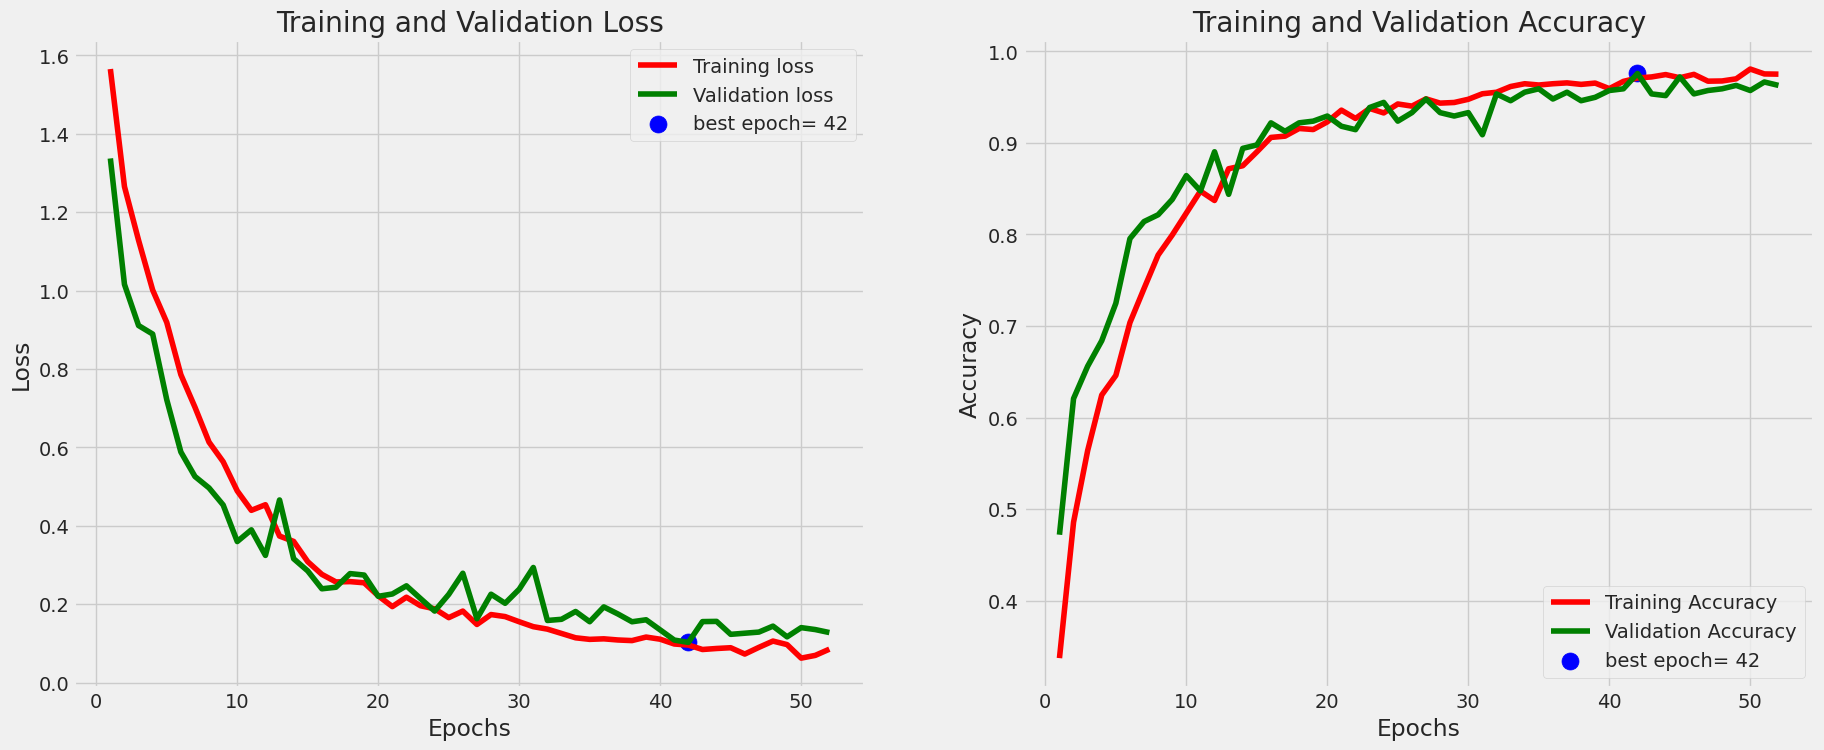

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9656 - loss: 0.1327
accuracy on the test set is 97.02 %

Model saved at: /kaggle/working/mobilenetse-fraktur-97.02.h5


In [25]:
tr_plot(history, 0)

save_dir = '/kaggle/working/'  
subject = 'fraktur'
model_name = 'mobilenetse'

acc = mobilenetse.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')
save_loc = os.path.join(save_dir, save_id)
mobilenetse.save(save_loc)

print(f'Model saved at: {save_loc}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


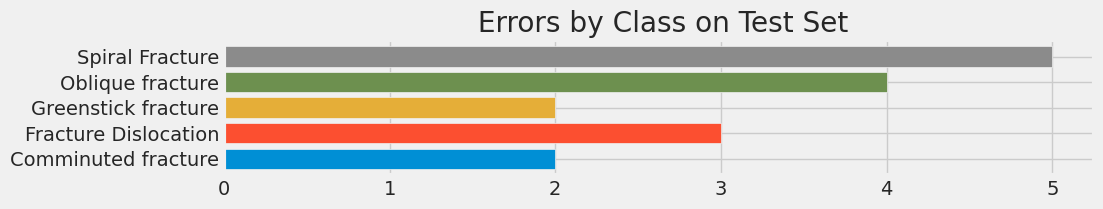

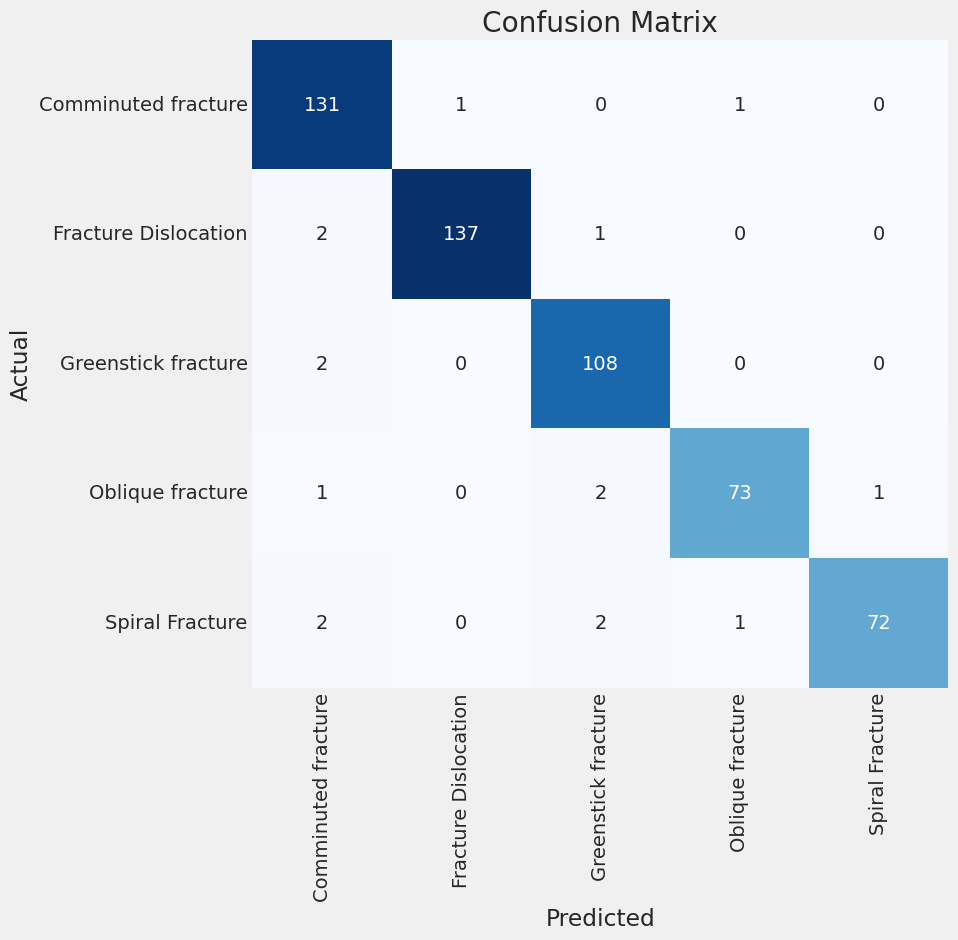

Classification Report:
----------------------
                       precision    recall  f1-score   support

 Comminuted fracture       0.95      0.98      0.97       133
Fracture Dislocation       0.99      0.98      0.99       140
 Greenstick fracture       0.96      0.98      0.97       110
    Oblique fracture       0.97      0.95      0.96        77
     Spiral Fracture       0.99      0.94      0.96        77

            accuracy                           0.97       537
           macro avg       0.97      0.97      0.97       537
        weighted avg       0.97      0.97      0.97       537



In [26]:
print_code=0
preds=mobilenetse.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )